In [1]:
# Import modules
# ipython magic to plot in line
%matplotlib inline
#import mpld3
#mpld3.enable_notebook()
import matplotlib
#matplotlib.style.use('ggplot')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from astropy.io import ascii
import pytz
# OS interaction
import sys
import os
import glob
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
Stations_all = ['BNS','CRG','CRN','FLG','FRG','FRS','PWL']

In [3]:
# Set font size
font = {'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)

In [4]:
# Directories
# Path to raw data
 # Win path
#mod_dir   = os.path.normpath('C:\\Users\\new356\Model_Output\CHM\SnowCast')
 # Linux path
mod_dir   = os.path.normpath(r'/home/nwayand/snow_models/output_CHM/SnowCast)

# Model output ending
mod_ending   = '*_out.txt'

In [5]:
# Define input format of ascii files
input_format = 'CHM'

In [6]:
if input_format == 'CHM':
    # Ascii data format info
    c_header = 1 # Header lines
    c_column_line = 1 # line where column names start
    c_delimiter = ','

In [7]:
# Move to Model dir
os.chdir(mod_dir) 

In [8]:
def plot_station_weather(datain):
    ## Multiple axes
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    # Var to plot
    t = datain['t']
    p = datain['p']
    p_snow = datain['p_snow']
    ctime = t.index

    fig = plt.figure()
    fig.set_size_inches(16, 8,forward=True)
    host = host_subplot(111, axes_class=AA.Axes)

    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 70
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",axes=par2, offset=(offset, 0))

    par2.axis["right"].toggle(all=True)

    #host.set_xlim()
    host.set_ylim(t.min(), t.max())

    host.set_xlabel("Time (MST)")
    host.set_ylabel("Air Temperature (C)")

    par1.set_ylabel("Precipitation (mm)")
    par2.set_ylabel("Frozen Precipitation (mm)")

    p1, = host.plot(ctime, t, label="Air Temperature (C)")
    p2, = par1.plot(ctime, p, label="Precipitation (mm)")
    p3, = par2.plot(ctime, p_snow, label="Frozen Precipitation (mm)")

    par1.set_ylim(0, p.max())
    par2.set_ylim(0, p.max())

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    plt.title(cSta)

In [25]:
def plot_station_snow_soil(datain):
    ## Multiple axes
    from mpl_toolkits.axes_grid1 import host_subplot
    import mpl_toolkits.axisartist as AA

    # Var to plot
    var1 = datain['swe']
    var2 = datain['snowdepthavg']
    var3 = datain['snow_albedo']
    ctime = var1.index

    fig = plt.figure()
    fig.set_size_inches(14, 8,forward=True)
    host = host_subplot(111, axes_class=AA.Axes)

    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()

    offset = 120
    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right",axes=par2, offset=(offset, 0))

    par2.axis["right"].toggle(all=True)
    
    #host.set_xlim()
    host.set_ylim(0, var1.max())

    host.set_xlabel("Time (MST)")
    host.set_ylabel("SWE (mm)")

    par1.set_ylabel("Snow Depth (mm)")
    par2.set_ylabel("Snow Albedo (-)")

    p1, = host.plot(ctime, var1, label="SWE (mm)")
    p2, = par1.plot(ctime, var2, label="Snow Depth (mm)")
    p3, = par2.plot(ctime, var3, label="Snow Albedo (-)")

    par1.set_ylim(0, var2.max())
    par2.set_ylim(0, 1)

    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())

    plt.title(cSta)
    
    # Try to rotate the xaxes labels (not working!!!)
    par1.axis["bottom"].major_ticklabels.set_axis_direction("bottom")
    par1.axis["bottom"].major_ticklabels.set_rotation(90)

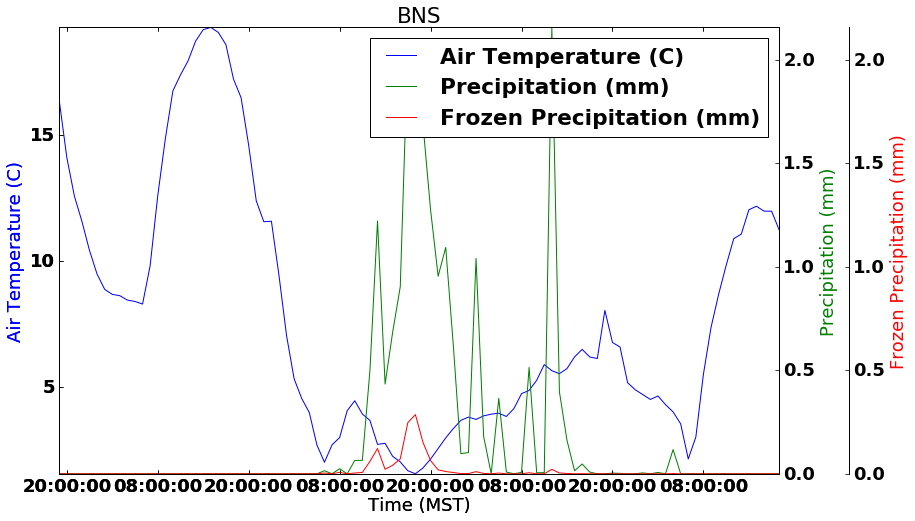

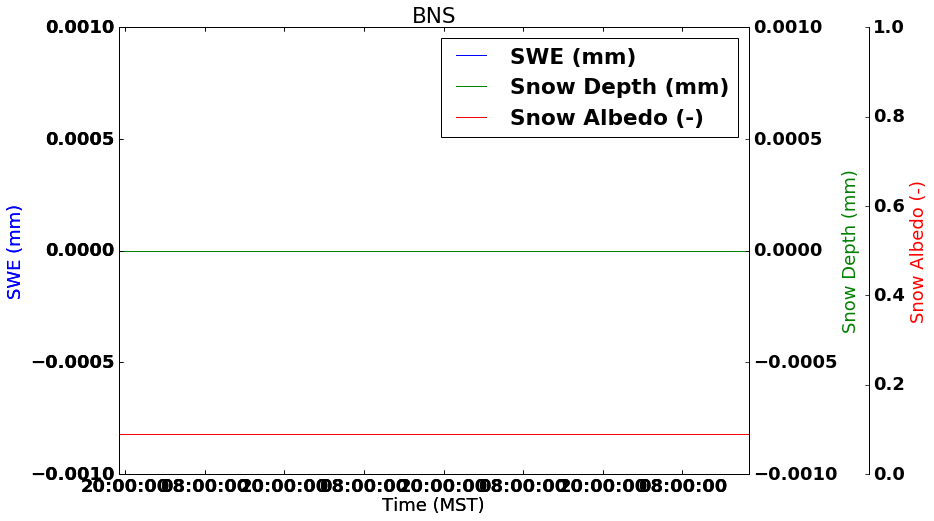

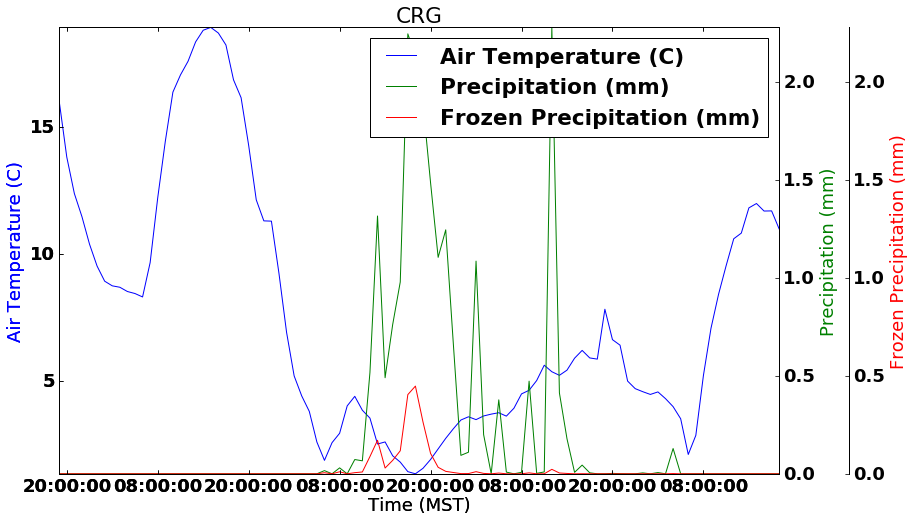

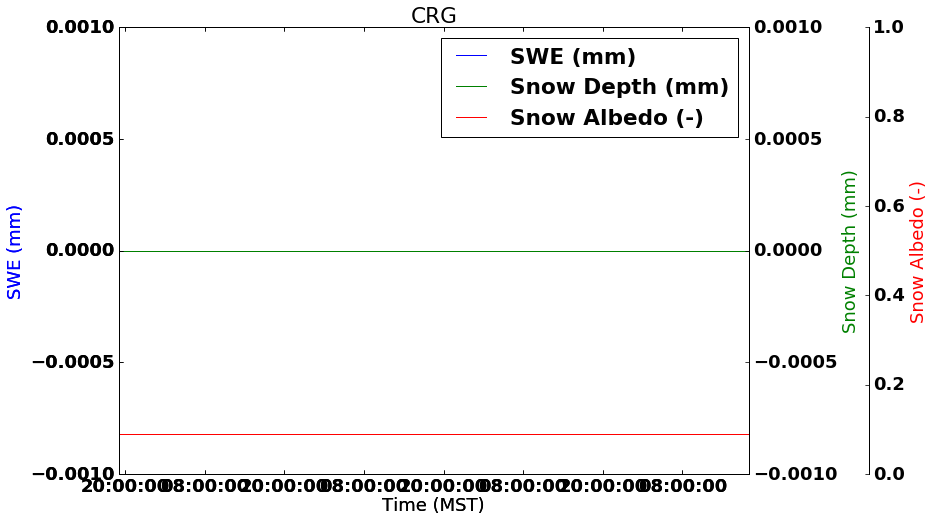

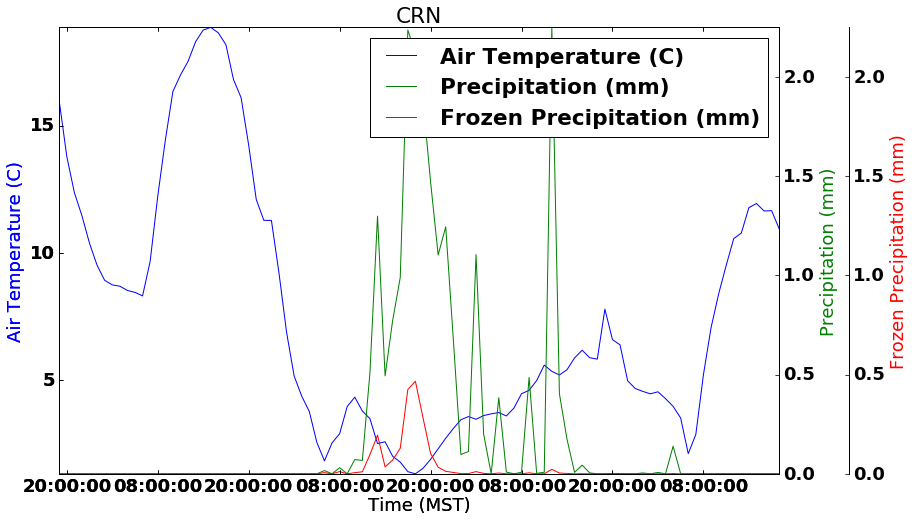

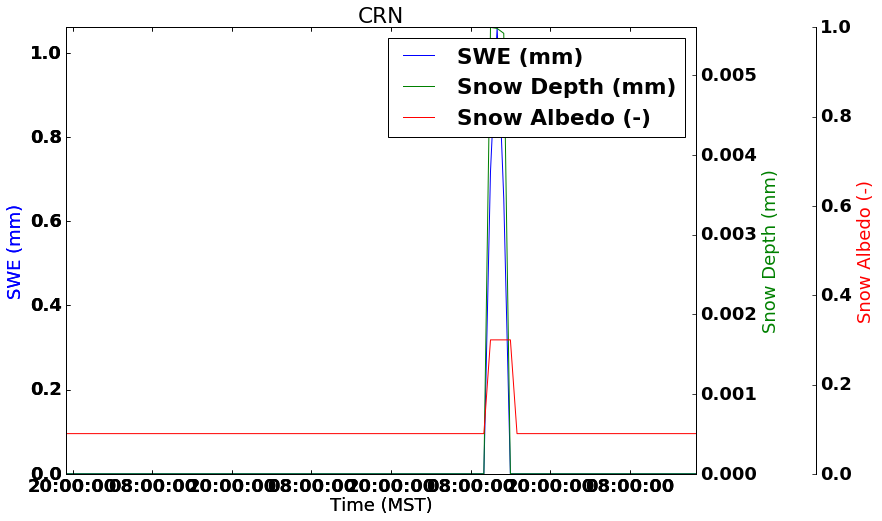

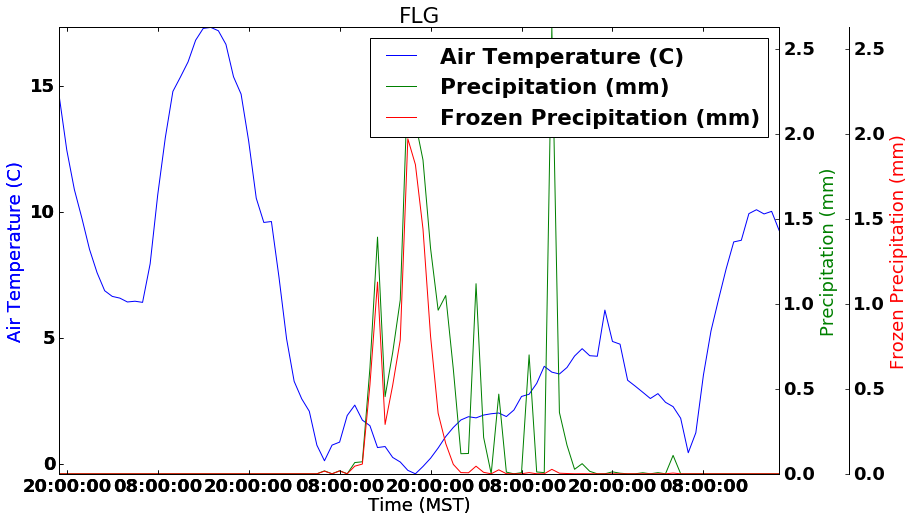

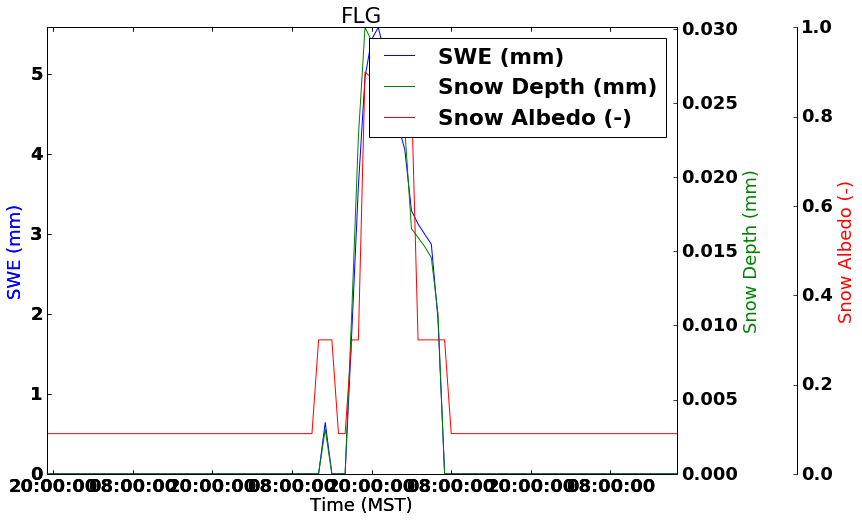

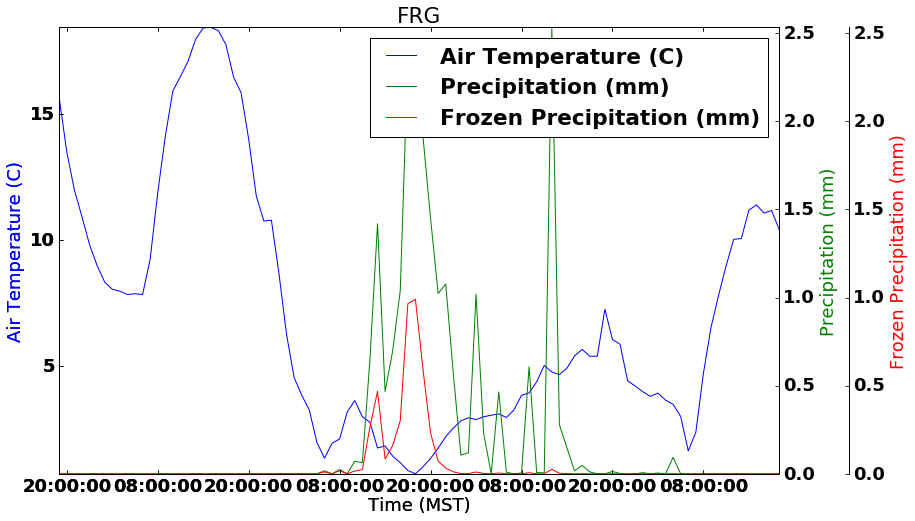

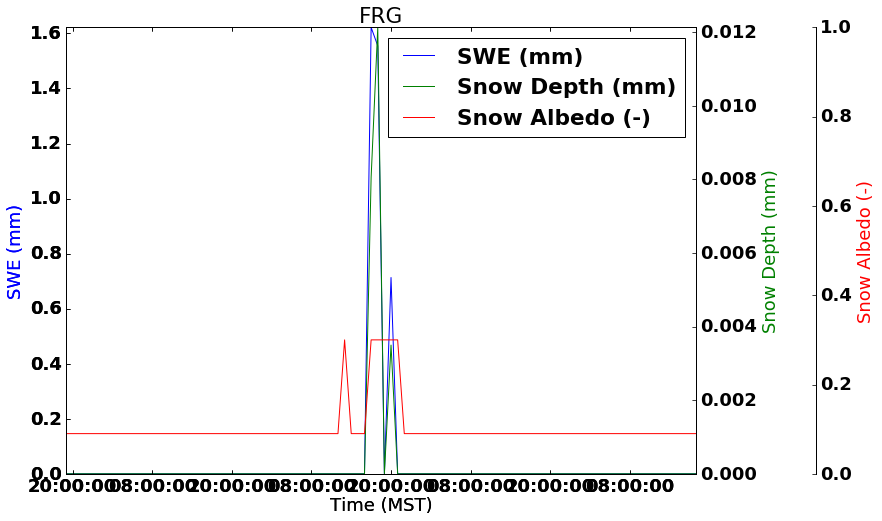

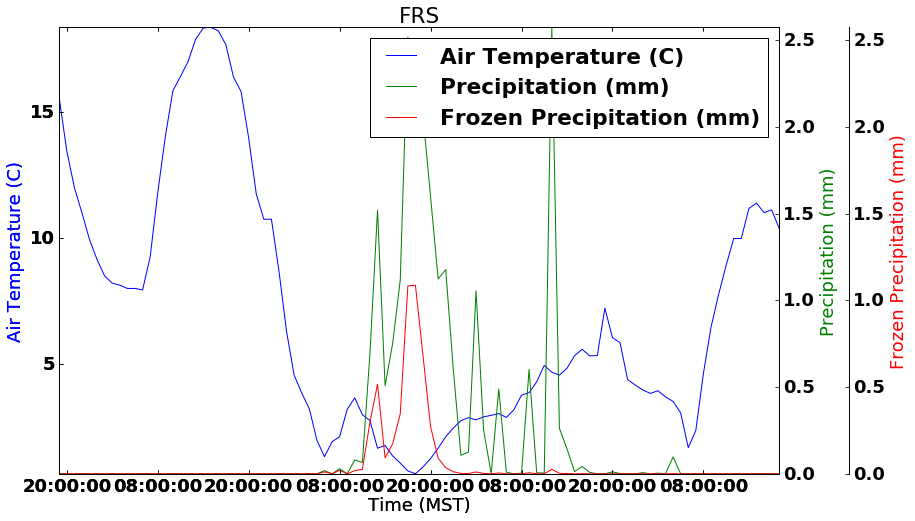

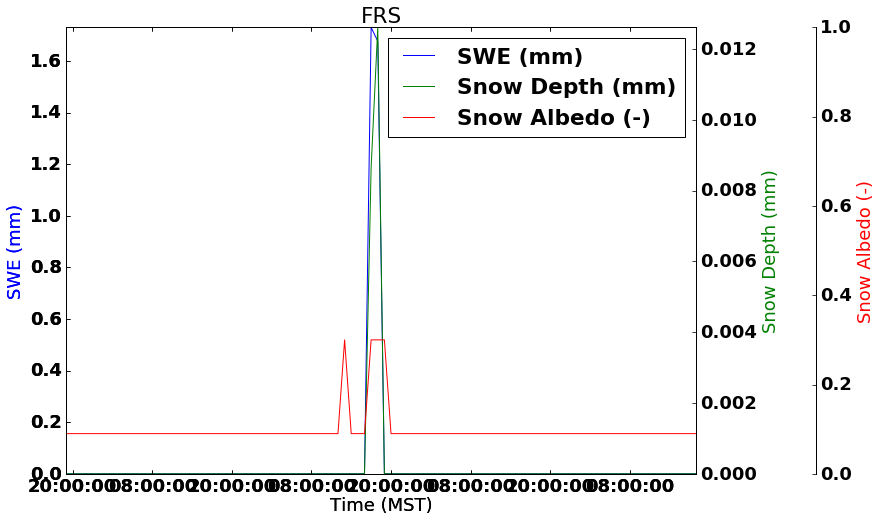

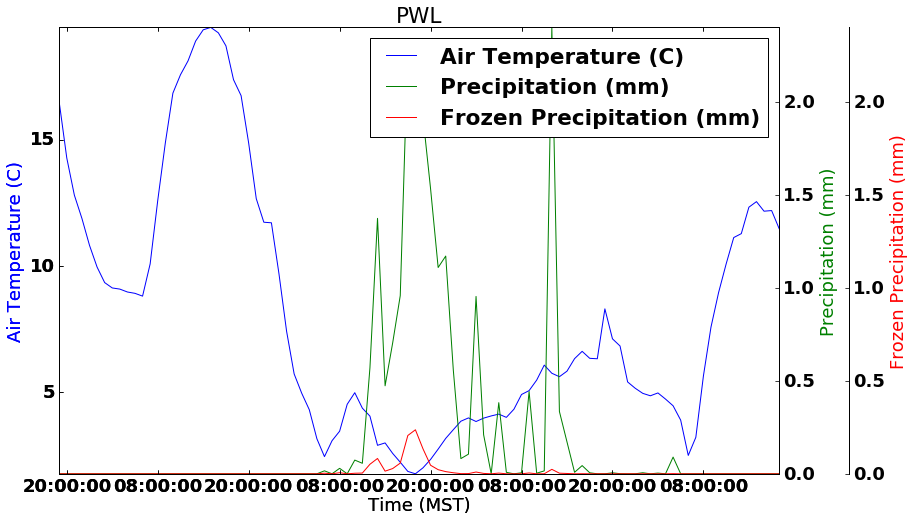

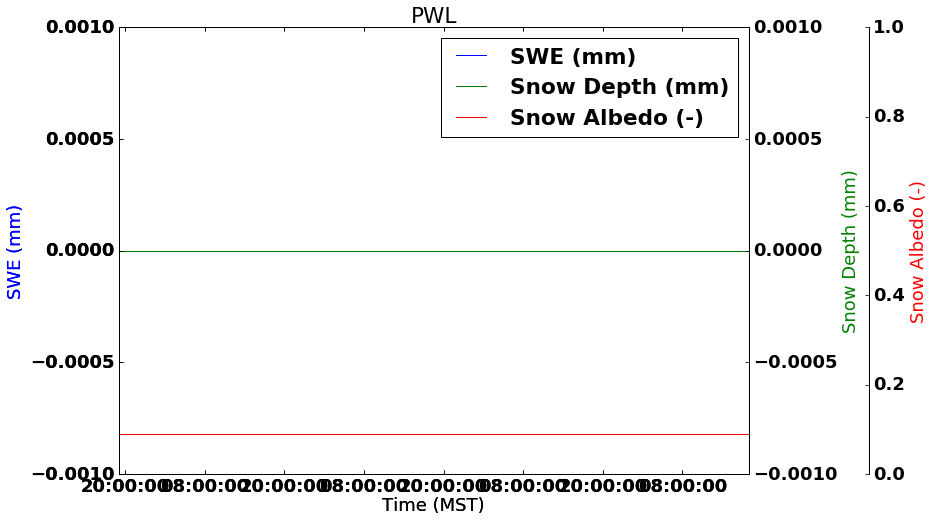

In [26]:
# For Each station
for cSta in Stations_all:
    #print(cSta)
    ###### Import model output file
    cfile = cSta + '_out.txt'
    
    # Import data to pandas dataframe
    datain = pd.read_csv(cfile,sep=",",parse_dates=True) 
    datain.set_index('datetime',inplace=True)

    # Make datetime the index
    datain.index = pd.to_datetime(datain.index)
    
    # Convert CHM non-standard units 
    #datain['p']   = datain['p']/1000 # mm to m
    #datain['swe'] = datain['swe']/1000 # mm to m

    ###########################
    # Plot key vars for station
    ###########################
    
    plot_station_weather(datain)
    
    plot_station_snow_soil(datain)
    